<a href="https://colab.research.google.com/github/ADACS-Australia/LMS-How-to-debug-Python-edition-/blob/master/morphology_classification_debugged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Foreword
The following code is a modified extract of the masters thesis of Leonie Chevalier studing Low redshift extreme star-forming galaxies in a subset of the GAMA survey.
In this particular snippet of code we are examining galaxy morphology using various structural parameters. Measurements of their asymmetry, smoothness and concentration were used to compare them to other galaxy populations such as dwarf elliptical galaxies.

Extreme star-forming galaxies are those forming stars at a rate well above the local average.
Low redshift extreme star-forming galaxies provide us with an alternative method of studying galaxy evolution at high redshifts. Due to their high levels of star-formation they are an analogue to galaxies that make up the main population at high redshift. The high rate of star forming activity may be due to these galaxies may have undergone recent mergers or are only just now forming their first population of stars.

While the original sample contained 175 galaxies the github repoaccompaning this notebook  only contains a small subset of thumbnails to try your hand on if you choose to.

Find evyerthing at : https://github.com/ADACS-Australia/LMS-How-to-debug-Python-edition-

# Your Task

This code has several delightful bugs introduced to it. 
Your job is getting it to 1. run without throwing an exception 2. double check that your results are sensible (hint: initially they won't be we made sure of that)

In [0]:
#--------DATA-------#

import matplotlib
#matplotlib.use('TkAgg')
import numpy as np
import matplotlib.gridspec as grid
import scipy.misc
import scipy.ndimage
from astropy.convolution import *
import matplotlib.pyplot as plt
import random as rnd
from astropy.io import fits
import sys
import fnmatch
import os
import pylab as py
#import pyfits as pyfit

%matplotlib inline

In [0]:


#----mock imput data-----#
np.random.seed(0)
datapoints = 10000
x_data1 = np.random.standard_normal(datapoints) #for i in range (0, datapoints)]
y_data1 = np.random.standard_normal(datapoints) #for i in range (0, datapoints)]

x_data2 = np.random.standard_normal(datapoints)+1
y_data2 = np.random.standard_normal(datapoints)+1

x_data3 = np.random.standard_normal(datapoints)+1
y_data3 = np.random.standard_normal(datapoints)+3

x_data4 = np.random.standard_normal(datapoints)*1.5
y_data4 = np.random.standard_normal(datapoints)*1.5

x_data5 = np.random.standard_normal(datapoints)-1 
y_data5 = np.random.standard_normal(datapoints)-1

x_data6 = np.random.standard_normal(datapoints)-1
y_data6 = np.random.standard_normal(datapoints)-3

x_data = x_data3+x_data2+x_data1+x_data4
y_data = y_data3+y_data2+y_data1+y_data4

H1, xedges, yedges = np.histogram2d(y_data1, x_data1, bins=np.arange(-5.,5.1,0.05))
H2, xedges, yedges = np.histogram2d(y_data2, x_data2, bins=np.arange(-5.,5.1,0.05))
H3, xedges, yedges = np.histogram2d(y_data3, x_data3, bins=np.arange(-5.,5.1,0.05))
H4, xedges, yedges = np.histogram2d(y_data4, x_data4, bins=np.arange(-5.,5.1,0.05))
H5, xedges, yedges = np.histogram2d(y_data5, x_data5, bins=np.arange(-5.,5.1,0.05))
H6, xedges, yedges = np.histogram2d(y_data6, x_data6, bins=np.arange(-5.,5.1,0.05))

# ---- finished mock galaxies
B = np.ones((1000,1000))
lumpy= H1+H2+H3+H4
morelumpy= H1+H2+H3+H4+H5+H6+H1+H2+H3+H4
gaussian = H1
noisygaussian = H1+H4
symmetric = H5+H2

#----------------------##----------------------#
######SDSS-MORPH CODE#######

def aperture_crider(image, radius):
    mask_image = np.copy(image)
    lx, ly = mask_image.shape
    X, Y = np.ogrid[0:lx, 0:ly]
    mask = (X - lx / 2) ** 2 + (Y - ly / 2) ** 2 > radius**2
    mask_image[mask] = 0
    n_pixels = float(lx*ly - mask.sum())
    return float(mask_image.sum()), n_pixels
    
def petrosian_radius(image):
    # http://spiff.rit.edu/classes/phys443/lectures/gal_1/petro/petro.html
    lx, ly = image.shape
    n = int(min([lx/2, ly/2]))

    r = np.arange(n)
    counts = np.arange(n, dtype=np.float)
    pixels = np.arange(n)

    for i in r:
        counts[i], pixels[i] = aperture_crider(image, i)
            
    local_intensity = (counts[1:n-1] - counts[0:n-2])/(pixels[1:n-1] - pixels[0:n-2])
    eta = local_intensity / (counts[1:n-1] / pixels[1:n-1])
    
    # Use ETA cutoff of 0.2 as SDSS does.
    radii = r[np.where(eta<=0.2)]
    petradius=  radii[0]
    return petradius      
#----------------------##----------------------#
#----------------------##----------------------#
def appt(radius,image):
    #line ne possibly taken out when run with stamp!! make function to make stamps of everything !!
    centera,centerb = scipy.ndimage.measurements.center_of_mass(image)
    nx,ny = image.shape
    y,x = np.ogrid[-centera:nx-centera,-centerb:ny-centerb]
    mask = x*x + y*y <= radius*radius
    counts =   sum(image[mask]) 
    return counts

def light_profile(image):
    x,y = image.shape
    n =min([x/2, y/2]) # /2 due to radius calculation
    I=[]
    for i in np.arange(1,n+1.):# start at radius of 1 then work outwards keep 0 for Io??
        I.append(appt(i,image))
    return I

def halflight_radius(image):  
    x,y = image.shape
    I = light_profile(image)
    L = I/I[len(I)-1]
    HL = np.argmax(L>=0.5)
    return HL, L[HL]
       
        #possible problem due to working in counts and not in counts per pixel ?    
def petrosian_radius_own(image): 
    lx =np.arange(image.shape[0]) #lenght of x axis
    ly = np.arange(image.shape[1])#lenght of y axis
    coordinates = [np.meshgrid(lx,ly)]#---->list
    gal_coord = np.where (image>0) 
    #Intensity_total = np.sum(image)
    Intensities = image[coordinates] #galaxy only excludes 0s
    #Intensity_mean =np.mean( image[gal_coord])
    K =light_profile(image)
    r= np.arange(1,len(K),1)
    
    pet_frac=[light_profile(image)[0]]
    for i in r:
        pet_frac.append(np.mean(light_profile(image)[:i+1])/(light_profile[i]-light_profile(image)[i-1]))
       
    pr =np.where(np.array(pet_frac) <=5)# something wrong with cut off !!!
    #petradius=  np.min(pr)
    return pr,pet_frac
    
def smoothness(image):
    original = image
    pr =0.1*petrosian_radius(image)
    smooth = convolve(original,Box2DKernel(pr))
    plt.figure()
    G = grid.GridSpec (2,2)
    axes_1 = py.subplot(G[0, :-1])
    plt.imshow(image, interpolation = 'none')
    plt.title('Original')
    #pl.plot(X,Y,"k:",ms=1,linewidth=2.0)
    axes_2 = py.subplot(G[0, -1])
    plt. imshow(smooth, interpolation = 'none')
    plt.title('Smoothed')
    smoothness_factor = np.sum(np.abs(image-smooth))/np.sum(image)
    #print smoothness_factor
    axes_3 = py.subplot(G[1, :])
    plt.imshow((image-smooth), interpolation ='none')
    plt.show()  
    return smoothness_factor
    
def concentration(image):
    x,y = image.shape
    I = light_profile(image)
    L = I/I[len(I)-1]
    HL = np.argmax(L>=0.5)
    C20 =  np.argmax(L>=0.2)
    C80 =  np.argmax(L>=0.8)
    C=5*np.log10(C80/C20)
    return C
    
def stamp(image):
    center =scipy.ndimage.measurements.center_of_mass(image)
    centery = center[0]
    centerx= center[1]
    #print 'Center',center
# crop image to center on barycenter coordianates
# try to define offset rom real center and then crop from there [miny+Ay:maxy+Ay,minx+Ax:maxx+Ax]

    R_Y=len(yedges)/2
    R_X= len(xedges)/2
    Ax = int(centerx-R_X)
    Ay = int(centery-R_Y)
    #print 'X dimension', centerx, R_X
    #print 'Y dmension', centery, R_Y

    stamp = image[Ay:len(yedges)+Ay, Ax:len(xedges)+Ax]
    return stamp


def Asymetry(image):
    
    R = np.rot90((image),2)
    Asym =np.sum(np.abs((image)-R))/np.sum((image))
     
    plt.figure()
    G = grid.GridSpec (2,2)
    axes_1 = py.subplot(G[0, :-1])
    plt.imshow((image), interpolation = 'none')
    plt.title('Original')
    axes_2 = py.subplot(G[0, -1])
    plt. imshow(R, interpolation = 'none')
    plt.title('Rotated')
    axes_3 = py.subplot(G[1, :])
    plt.imshow((image)-R, interpolation = 'none')
    plt.show()
    #plt.savefig(str(image)+'.png')
    return Asym
    
    
def Morph(image):
    asymetry = Asymetry(image)
    con = concentration(image)
    halflight =halflight_radius(image)
    profile =light_profile(image)
    smoothed = smoothness(image)
    return asymetry,con, smoothed
    

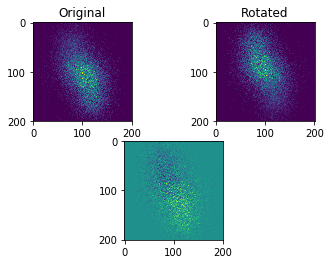

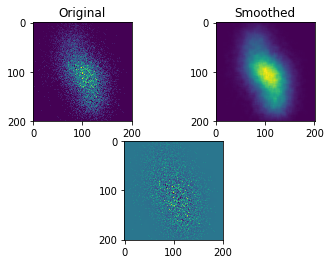

(0.7019387570211995, 2.421499196733929, 0.4610484645215518)

In [3]:
Morph(morelumpy)

# There is more!

The mock data we provided in the previous cells is very simple, just a few gaussians and noise. That has been enough to demonstate and test the concept of what we wanted our functions to achieve.
However when this code was first written it was intended to process and classify the morphology of a large subset of galaxies from the GAMA survey.

The galaxy images are stored in fits files and are decidedly larger and more complex then our test galaxies. While writing the test cases we wanted to get as close to the real problem as possibl while keeping it small and managable and most importantly simple to code up and not introduce weird and wonderful bugs. However as they are so much more simplified this means we will almost certainly run into something we haven't taken into consideration or were not expecting. So don't panic if it does not work the first time round and you have to make adjustments.



In [4]:
import astropy.io.fits as fits

target_url = 'https://github.com/ADACS-Australia/LMS-How-to-debug-Python-edition-/blob/master/thumbnails/G231200_SDSS_r.fits?raw=true'

dat = fits.open(target_url,ignore_missing_end=True)



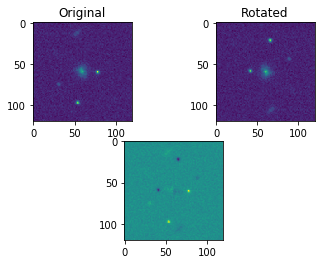

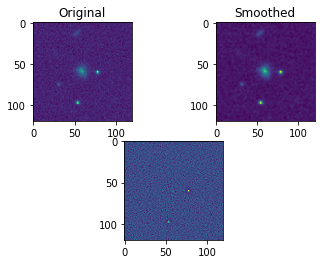

(3.5384917, 4.5690692619185835, 1.4592648)

In [5]:
image = dat[0].data
Morph(image)

As you can see on this fits file from the GAMA survey our code still ran without error. But you can see that the galaxy in the image is rather small and there are other objects/ noise in the image that could influance any measrurements. As an *Excercise* try using the *stamp* funcation to create smaller images centered on the galaxy that cut out most of the unwanted stuff.

And to take it a step further check out the rest of the thumbnails in our github repository!